In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV, train_test_split


In [67]:
columns = [
    "Loan_ID", "Gender", "Married", "Dependents", "Education", "Self_Employed",
    "ApplicantIncome", "CoapplicantIncome", "Loan_Amount", "Loan_Amount_Term",
    "Credit_History", "Property_Area", "Loan_Status"
]

In [68]:
df = pd.read_csv('loan_prediction.csv', header=None, names=columns)
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,Loan_Amount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Loan Rejection or Approval Status Prediction Loan application data with approval status results.

This dataset contains information about past loan applicants, including their income, loan amount, credit history, and other factors relevant to loan approval decisions.

The goal is to build a machine learning model that can analyze this data to predict whether future loan applications should be approved or rejected.



In [69]:
df.shape

(614, 13)

In [70]:
drop_columns=['Loan_ID']
df.drop(columns=drop_columns,inplace=True)

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   Loan_Amount        592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


# Dependents should be int rather than object

In [72]:
df['Dependents'].value_counts()

0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64

In [73]:
df['Dependents'] = df['Dependents'].replace('3+', '3')

In [74]:
df['Dependents'].value_counts()

0    345
1    102
2    101
3     51
Name: Dependents, dtype: int64

In [75]:
df['Dependents'] = df['Dependents'].astype("float64")

# Since Gender cannot be determined , we will remove null value rows by Gender

In [76]:
df = df.dropna(subset='Gender')

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 601 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            598 non-null    object 
 2   Dependents         586 non-null    float64
 3   Education          601 non-null    object 
 4   Self_Employed      569 non-null    object 
 5   ApplicantIncome    601 non-null    int64  
 6   CoapplicantIncome  601 non-null    float64
 7   Loan_Amount        579 non-null    float64
 8   Loan_Amount_Term   587 non-null    float64
 9   Credit_History     552 non-null    float64
 10  Property_Area      601 non-null    object 
 11  Loan_Status        601 non-null    object 
dtypes: float64(5), int64(1), object(6)
memory usage: 61.0+ KB


In [78]:
df["Gender"].value_counts()

Male      489
Female    112
Name: Gender, dtype: int64

In [79]:
mapping={"Male":1,"Female":0}
df["Gender"]=df["Gender"].map(mapping)

In [80]:
mapping={"Yes":1,"No":0}
df["Married"]=df["Married"].map(mapping)

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 601 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    int64  
 1   Married            598 non-null    float64
 2   Dependents         586 non-null    float64
 3   Education          601 non-null    object 
 4   Self_Employed      569 non-null    object 
 5   ApplicantIncome    601 non-null    int64  
 6   CoapplicantIncome  601 non-null    float64
 7   Loan_Amount        579 non-null    float64
 8   Loan_Amount_Term   587 non-null    float64
 9   Credit_History     552 non-null    float64
 10  Property_Area      601 non-null    object 
 11  Loan_Status        601 non-null    object 
dtypes: float64(6), int64(2), object(4)
memory usage: 61.0+ KB


In [82]:
condition1 = (df['Married'] == 0)
condition2 = (df['Gender'] == 0)

# Define the value to impute
impute_value = 0

# Use boolean indexing to fill NaN values based on multiple conditions
df.loc[condition1 & condition2, 'Dependents'] = df.loc[condition1 & condition2, 'Dependents'].fillna(impute_value)

In [83]:
df['Property_Area'].value_counts()

Semiurban    227
Urban        199
Rural        175
Name: Property_Area, dtype: int64

In [84]:
mapping={"Rural":0,'Semiurban':1,'Urban':2}
df['Property_Area']=df['Property_Area'].map(mapping)

In [85]:
mapping={'Y':1,"N":0}
df['Loan_Status']=df['Loan_Status'].map(mapping)

In [86]:
df['Education'].value_counts()

Graduate        468
Not Graduate    133
Name: Education, dtype: int64

In [87]:
mapping={"Graduate":1,"Not Graduate":0}
df['Education']=df['Education'].map(mapping)

In [88]:
df['Self_Employed'].value_counts()

No     491
Yes     78
Name: Self_Employed, dtype: int64

In [89]:
mapping={"No":0,"Yes":1}
df['Self_Employed']=df['Self_Employed'].map(mapping)

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 601 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    int64  
 1   Married            598 non-null    float64
 2   Dependents         588 non-null    float64
 3   Education          601 non-null    int64  
 4   Self_Employed      569 non-null    float64
 5   ApplicantIncome    601 non-null    int64  
 6   CoapplicantIncome  601 non-null    float64
 7   Loan_Amount        579 non-null    float64
 8   Loan_Amount_Term   587 non-null    float64
 9   Credit_History     552 non-null    float64
 10  Property_Area      601 non-null    int64  
 11  Loan_Status        601 non-null    int64  
dtypes: float64(7), int64(5)
memory usage: 61.0 KB


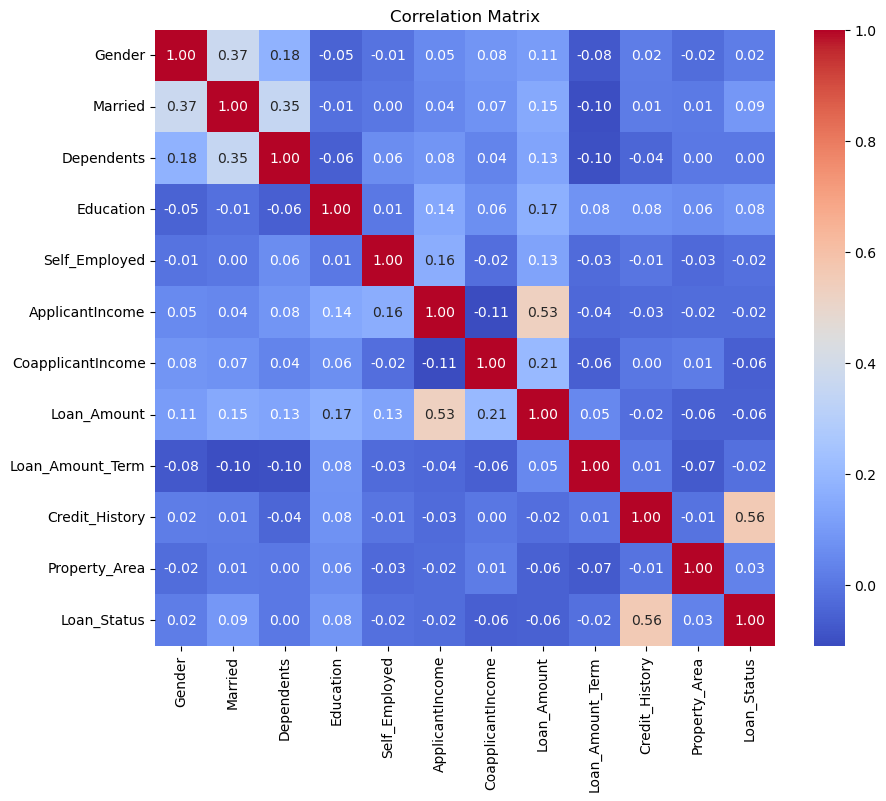

In [91]:
import seaborn as sns
correlation_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the correlation matrix using seaborn's heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Add title and show the plot
plt.title('Correlation Matrix')
plt.show()

highly correlated values are as follows

1.Gender and Married

2.Dependents and Married

3.Applicant Income and Self Employed

4.Credit History and loan Status

5.Loan Ammount and applicantIncome

In [92]:
condition2=df["Married"]==1
df.loc[condition2,'Dependents']=df.loc[condition2,'Dependents'].fillna(1)

In [93]:
df=df.dropna(subset='Dependents')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 596 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             596 non-null    int64  
 1   Married            596 non-null    float64
 2   Dependents         596 non-null    float64
 3   Education          596 non-null    int64  
 4   Self_Employed      564 non-null    float64
 5   ApplicantIncome    596 non-null    int64  
 6   CoapplicantIncome  596 non-null    float64
 7   Loan_Amount        575 non-null    float64
 8   Loan_Amount_Term   582 non-null    float64
 9   Credit_History     547 non-null    float64
 10  Property_Area      596 non-null    int64  
 11  Loan_Status        596 non-null    int64  
dtypes: float64(7), int64(5)
memory usage: 60.5 KB


In [94]:
mean1 = df.groupby('Self_Employed')['ApplicantIncome'].mean()

In [95]:
mean1

Self_Employed
0.0    4913.670782
1.0    7477.948718
Name: ApplicantIncome, dtype: float64

In [96]:
condition1=df['Self_Employed']==0
df.loc[condition1,'ApplicantIncome']=df.loc[condition1,'ApplicantIncome'].fillna(3464)

In [97]:
condition1=df['Self_Employed']==1
df.loc[condition1,'ApplicantIncome']=df.loc[condition1,'ApplicantIncome'].fillna(4563)

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 596 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             596 non-null    int64  
 1   Married            596 non-null    float64
 2   Dependents         596 non-null    float64
 3   Education          596 non-null    int64  
 4   Self_Employed      564 non-null    float64
 5   ApplicantIncome    596 non-null    int64  
 6   CoapplicantIncome  596 non-null    float64
 7   Loan_Amount        575 non-null    float64
 8   Loan_Amount_Term   582 non-null    float64
 9   Credit_History     547 non-null    float64
 10  Property_Area      596 non-null    int64  
 11  Loan_Status        596 non-null    int64  
dtypes: float64(7), int64(5)
memory usage: 60.5 KB


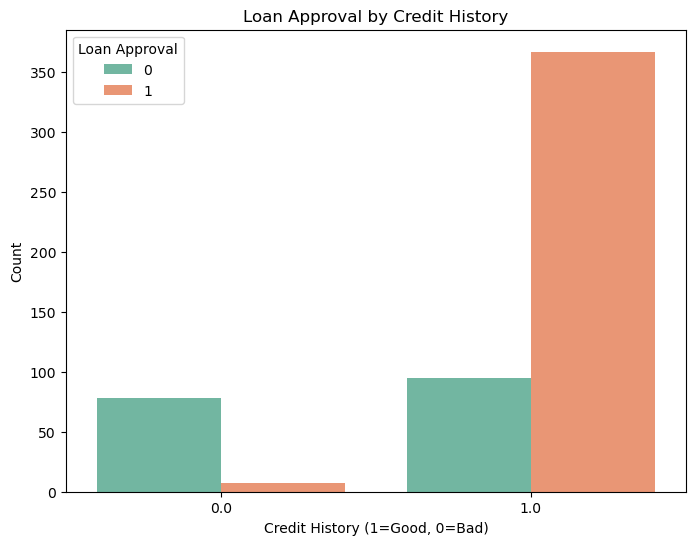

In [99]:
cross_tab = pd.crosstab(df['Credit_History'], df['Loan_Status'])

# Plot grouped bar chart
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Credit_History', hue='Loan_Status', palette='Set2')
plt.title('Loan Approval by Credit History')
plt.xlabel('Credit History (1=Good, 0=Bad)')
plt.ylabel('Count')
plt.legend(title='Loan Approval')
plt.show()

In [100]:
ondition2=df['Loan_Status']==1
df.loc[condition2,'Credit_History']=df.loc[condition2,'Credit_History'].fillna(1)
condition3=df['Loan_Status']==0
df.loc[condition3,'Credit_History']=df.loc[condition3,'Credit_History'].fillna(0)

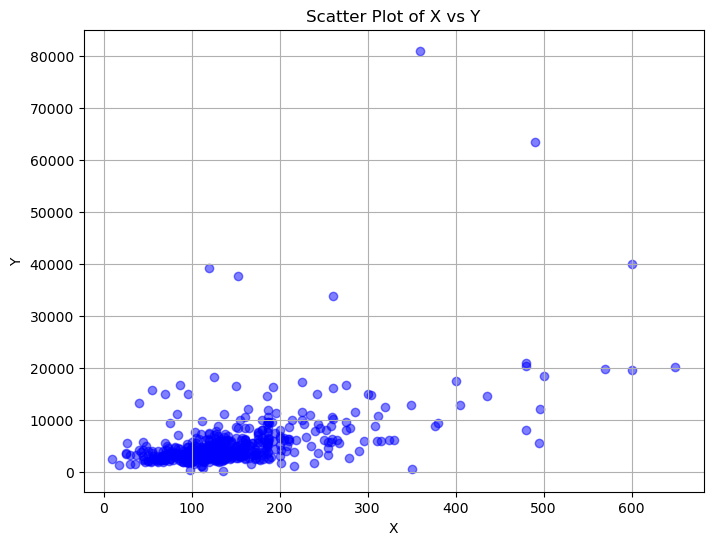

In [101]:
x_values = df['Loan_Amount']
y_values = df['ApplicantIncome']

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x_values, y_values, color='blue', alpha=0.5)  # Set the color and transparency
plt.title('Scatter Plot of X vs Y')  # Set the title
plt.xlabel('X')  # Set the x-axis label
plt.ylabel('Y')  # Set the y-axis label
plt.grid(True)  # Show grid
plt.show()

In [102]:
filtered_df = df[(df['ApplicantIncome'] > 1800) & (df['ApplicantIncome'] < 8000) & (df['Loan_Amount']>40)]

In [103]:
filtered_df['ApplicantIncome'].mean()

3926.2980972515857

In [104]:
df['ApplicantIncome'] = df['ApplicantIncome'].fillna(3602)

In [105]:
df = df.drop(columns='CoapplicantIncome',axis=1)

In [106]:
df['Loan_Amount_Term'].value_counts()

360.0    498
180.0     43
480.0     14
300.0     12
84.0       4
120.0      3
240.0      3
60.0       2
36.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

In [107]:
probabilities = [0.85, 0.08, 0.04,0.03]
# Impute values based on probabilities
imputed_values = np.random.choice([360, 180, 480,300], size=df['Loan_Amount_Term'].isnull().sum(), p=probabilities)

# Assign imputed values to NaN entries in the column
df.loc[df['Loan_Amount_Term'].isnull(), 'Loan_Amount_Term'] = imputed_values

In [108]:
filtered_df['Loan_Amount'].mean()

130.34672304439746

In [109]:
df['LoanAmount'] = df['Loan_Amount'].fillna(107)

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 596 entries, 0 to 613
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gender            596 non-null    int64  
 1   Married           596 non-null    float64
 2   Dependents        596 non-null    float64
 3   Education         596 non-null    int64  
 4   Self_Employed     564 non-null    float64
 5   ApplicantIncome   596 non-null    int64  
 6   Loan_Amount       575 non-null    float64
 7   Loan_Amount_Term  596 non-null    float64
 8   Credit_History    587 non-null    float64
 9   Property_Area     596 non-null    int64  
 10  Loan_Status       596 non-null    int64  
 11  LoanAmount        596 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 60.5 KB


In [111]:
df = df.dropna(subset='Education')

In [112]:
mean3 = df.groupby('Self_Employed')['ApplicantIncome'].mean()
mean3

Self_Employed
0.0    4913.670782
1.0    7477.948718
Name: ApplicantIncome, dtype: float64

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 596 entries, 0 to 613
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gender            596 non-null    int64  
 1   Married           596 non-null    float64
 2   Dependents        596 non-null    float64
 3   Education         596 non-null    int64  
 4   Self_Employed     564 non-null    float64
 5   ApplicantIncome   596 non-null    int64  
 6   Loan_Amount       575 non-null    float64
 7   Loan_Amount_Term  596 non-null    float64
 8   Credit_History    587 non-null    float64
 9   Property_Area     596 non-null    int64  
 10  Loan_Status       596 non-null    int64  
 11  LoanAmount        596 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 60.5 KB


In [114]:
df = df.dropna()

In [115]:
condition1=df['ApplicantIncome']>4000
df.loc[condition1,'Self_Employed']=df.loc[condition1,'Self_Employed'].fillna(1)
condition1=df['ApplicantIncome']<=4000
df.loc[condition1,'Self_Employed']=df.loc[condition1,'Self_Employed'].fillna(0)

In [116]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Create a random forest model
clf = RandomForestClassifier()
X = df.drop(columns=['Loan_Status'])
y = df['Loan_Status']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
# Train the model on training data
clf.fit(X_train, y_train)

# Predict class labels for test data
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy of the Random Forest Model: {accuracy:.4f}")

Accuracy of the Random Forest Model: 0.7407


In [117]:
accuracy_list=[]
for i in range(50):
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.metrics import accuracy_score

  clf = RandomForestClassifier()
  X = df.drop(columns=['Loan_Status'])
  y = df['Loan_Status']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  accuracy_list.append(accuracy)

In [118]:
accuracy_list.sort(reverse=True)

In [119]:
accuracy_list

[0.7654320987654321,
 0.7654320987654321,
 0.7654320987654321,
 0.7654320987654321,
 0.7654320987654321,
 0.7654320987654321,
 0.7654320987654321,
 0.7654320987654321,
 0.7654320987654321,
 0.7654320987654321,
 0.7654320987654321,
 0.7654320987654321,
 0.7654320987654321,
 0.7654320987654321,
 0.7654320987654321,
 0.7654320987654321,
 0.7654320987654321,
 0.7530864197530864,
 0.7530864197530864,
 0.7530864197530864,
 0.7530864197530864,
 0.7530864197530864,
 0.7530864197530864,
 0.7530864197530864,
 0.7530864197530864,
 0.7530864197530864,
 0.7530864197530864,
 0.7530864197530864,
 0.7530864197530864,
 0.7530864197530864,
 0.7530864197530864,
 0.7530864197530864,
 0.7530864197530864,
 0.7530864197530864,
 0.7530864197530864,
 0.7530864197530864,
 0.7407407407407407,
 0.7407407407407407,
 0.7407407407407407,
 0.7407407407407407,
 0.7407407407407407,
 0.7407407407407407,
 0.7407407407407407,
 0.7407407407407407,
 0.7407407407407407,
 0.7407407407407407,
 0.7407407407407407,
 0.7407407407

Higgest Accuracy achieved = 76.54%